In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess

import re

import pyLDAvis.gensim_models

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Soroush\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Soroush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Soroush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Soroush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Soroush\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Soroush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already

Loading dataset gathered from twitter by Scweet developed by https://github.com/Altimis

In [129]:
df = pd.read_csv('allstructuredtweets.csv', index_col=0)

In [117]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

Droping some of columns that we don't need. 

In [130]:
cols = ['id', 'date', 'username', 'name', 'place', 'tweet', 'language', 'hashtags']

for col in df.columns:
  if col not in cols:
    df.drop(col, axis=1, inplace=True)
df.head()

,id,date,username,name,place,tweet,language,hashtags
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,en,"['epr', 'freenet']"
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,en,"['zerowaste', 'plasticpollution', 'brandaudit'..."
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,en,"['zerowaste', 'plasticpollution', 'stopplastic..."
3,1427222591492722688,2021-08-16,jbvbin3t,Jean Babinet #noGreenwashing 💉💉,NaN,@buchebuche561 @ChSimonSU Ça fait longtemps qu...,fr,"['superphénix', 'epr']"
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,en,"['csr', 'epr', 'greenfinance', 'circulareconom..."


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228553 entries, 0 to 4186
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        228553 non-null  int64 
 1   date      228553 non-null  object
 2   username  228553 non-null  object
 3   name      228545 non-null  object
 4   place     1101 non-null    object
 5   tweet     228553 non-null  object
 6   language  228553 non-null  object
 7   hashtags  228553 non-null  object
dtypes: int64(1), object(7)
memory usage: 15.7+ MB


In [120]:
df.describe(include=object)

,date,username,name,place,tweet,language,hashtags
count,228553,228553,228545,1101,228553,228553,228553
unique,4753,94433,91641,882,194052,53,45092
top,2021-08-13,texaseconews,Texas Eco News,"{'type': 'Point', 'coordinates': [42.358424, -...",E-waste Management in Nigeria | Author: @saga...,en,[]
freq,7037,1411,1411,22,258,208286,127102


From the result of tweet_df.dexcribe, we can assume that companies are the most active users in this field, and that is probably because the iportance of consumer's awareness.

Since we are only interested to tweets in english, i will drope the other languages, but a little insight from variety of languages wouldn't hurt.

<AxesSubplot:xlabel='language', ylabel='id'>

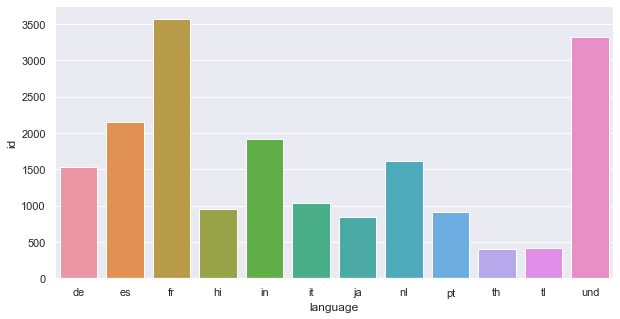

In [131]:
x = pd.DataFrame(df[df['language'] != 'en'].groupby('language')['id'].count())
x = x.reset_index()
x = x[x['id']>=300]
sns.barplot(data=x, x=x.language, y=x.id)

{ German, Spanish, French, Hindi, Italian, Japanese, Dutch, Portuguese, Thai } - 
These are twelve most used languages in tweets, and these are mostly developed countries. - 
FYI: und --> undetermined

Now we can drop other languages than english.

In [132]:
df = df[df['language'] == 'en']
df.head()

,id,date,username,name,place,tweet,language,hashtags
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,en,"['epr', 'freenet']"
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,en,"['zerowaste', 'plasticpollution', 'brandaudit'..."
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,en,"['zerowaste', 'plasticpollution', 'stopplastic..."
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,en,"['csr', 'epr', 'greenfinance', 'circulareconom..."
5,1427208574766358533,2021-08-16,allscriptsuk,Allscripts UK,NaN,@WWLNHS have been able to set their sights on ...,en,['epr']


To use date properly we should turn it to datetime format.

In [133]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,id,date,username,name,place,tweet,language,hashtags,year,month
0,1427294120360521728,2021-08-16,royalfreenhs,Royal Free London,NaN,We want RFL staff at each of our hospitals to ...,en,"['epr', 'freenet']",2021,8
1,1427283587536199683,2021-08-16,sarah_sauve,Sarah Sauvé,NaN,@NLZeroWaste has been working on this for a fe...,en,"['zerowaste', 'plasticpollution', 'brandaudit'...",2021,8
2,1427283232597417985,2021-08-16,sjcnl709,Social Justice Co-op NL,NaN,@NLZeroWaste has launched its 2021 Brand Audit...,en,"['zerowaste', 'plasticpollution', 'stopplastic...",2021,8
4,1427215153632849923,2021-08-16,circularaction,Circular Action Hub,NaN,Did you know that you can search for projects ...,en,"['csr', 'epr', 'greenfinance', 'circulareconom...",2021,8
5,1427208574766358533,2021-08-16,allscriptsuk,Allscripts UK,NaN,@WWLNHS have been able to set their sights on ...,en,['epr'],2021,8


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208286 entries, 0 to 4186
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        208286 non-null  int64         
 1   date      208286 non-null  datetime64[ns]
 2   username  208286 non-null  object        
 3   name      208278 non-null  object        
 4   place     989 non-null     object        
 5   tweet     208286 non-null  object        
 6   language  208286 non-null  object        
 7   hashtags  208286 non-null  object        
 8   year      208286 non-null  int64         
 9   month     208286 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 17.5+ MB


<AxesSubplot:>

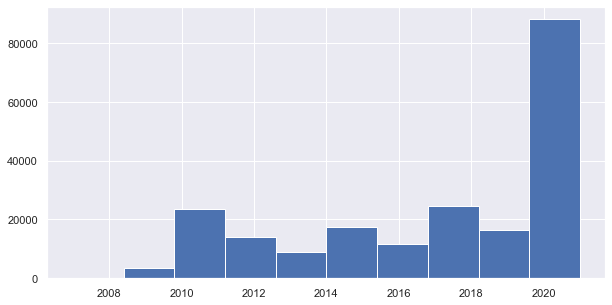

In [134]:
df['year'].hist()

Raise of number of tweets is evidence of increasing awareness and attention of various organizations and institutions to this issue.

Hashtags in our dataset is not stored as list, so we can not use it properly, in following we should makje this right.

In [136]:
df["hashtags"] = df["hashtags"].apply(eval)

Now that we can use hashtags column, we can represent most frequent hashtags used in tweets

In [138]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

hashtag_count = to_1D(df['hashtags']).value_counts()

In [139]:
hashtag_count = hashtag_count[hashtag_count >= 2000]

In [140]:
hashtag_count

weee                              16413
recycling                         13491
hazardouswaste                     9633
ewaste                             8526
epr                                7266
circulareconomy                    5966
recycle                            5898
electronicwaste                    3609
waste                              3499
sustainability                     3214
environment                        3066
extendedproducerresponsibility     2551
reuse                              2546
dtype: int64

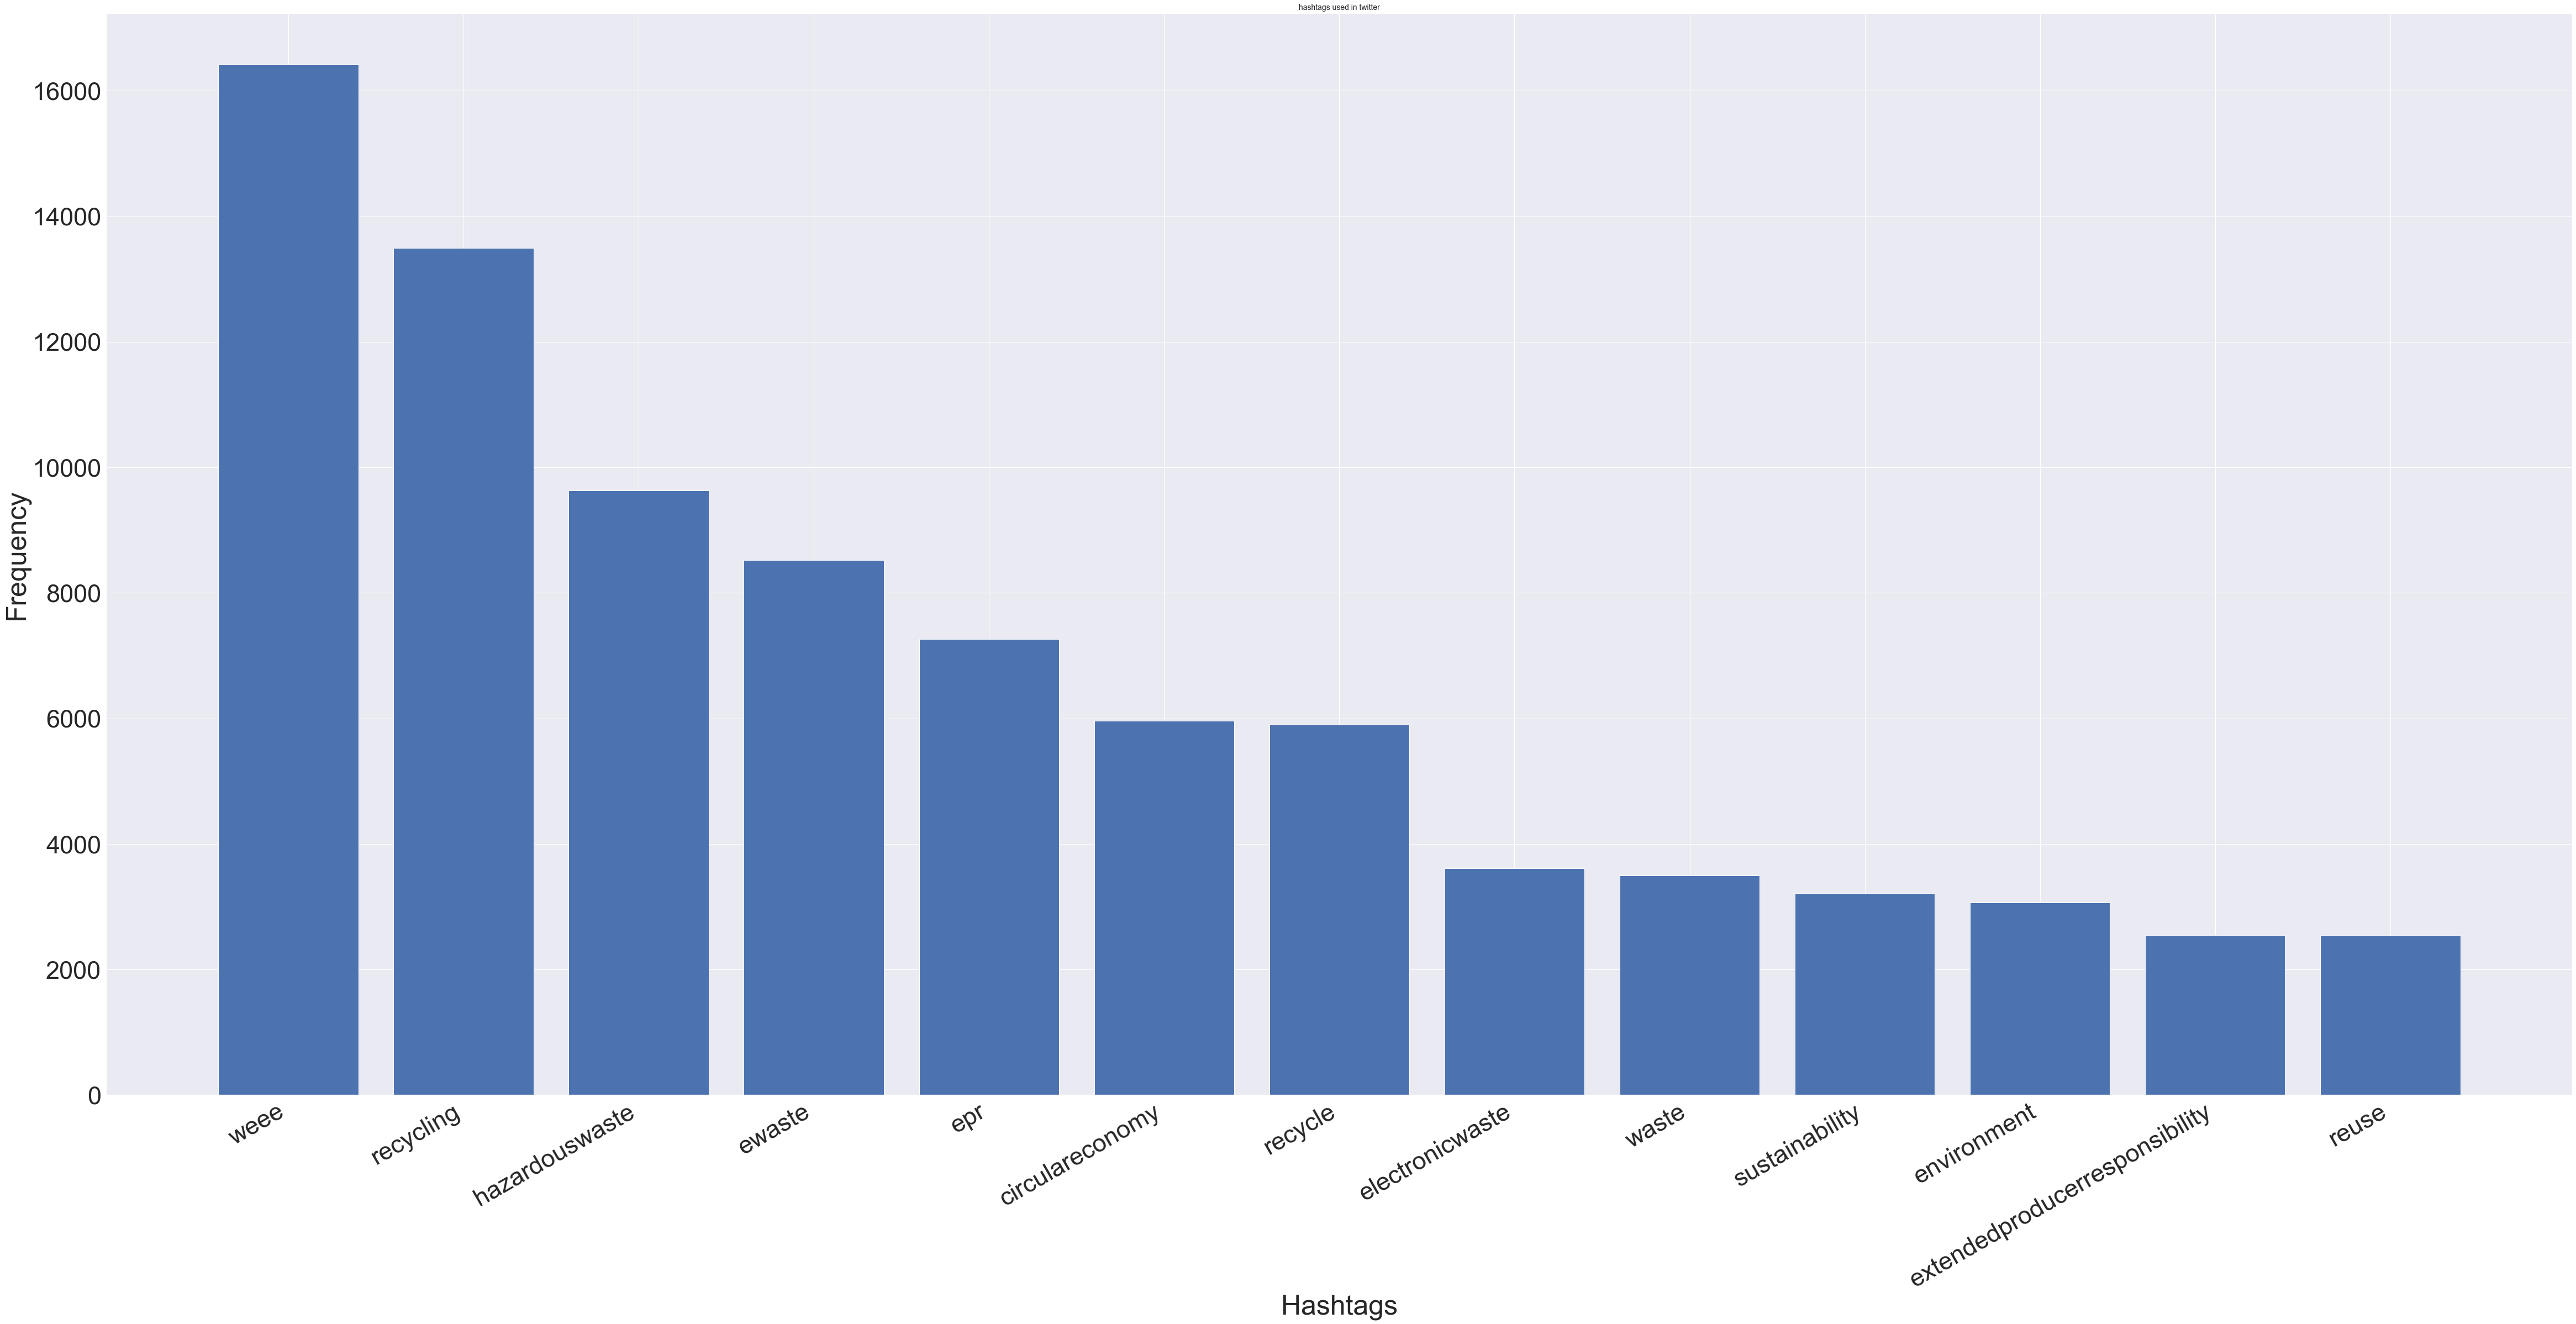

In [141]:
fig, ax = plt.subplots(figsize = (80,40))
ax.tick_params(axis='both', labelsize=45)
ax.bar(hashtag_count.index,
        hashtag_count.values)
ax.set_ylabel("Frequency", size = 50)
ax.set_xlabel("Hashtags", size = 50)
ax.set_title("hashtags used in twitter", size = 14)
fig.autofmt_xdate()

It would be a good idea to see how some of the most frequent hashtags change through years

In [142]:
group_hash = df.groupby('year')['hashtags'].apply(lambda x: to_1D(x).value_counts())

C:\Users\Soroush\AppData\Local\Temp/ipykernel_11256/1321968891.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([x for _list in series for x in _list])


In [143]:
hashPerYear = pd.DataFrame(group_hash)
hashPerYear.reset_index(level=0, inplace=True)
hashPerYear.reset_index(level=0, inplace=True)
hashPerYear = hashPerYear.rename({'index': 'hashtag', 'hashtags': 'count'}, axis=1)
hashPerYear

,hashtag,year,count
0,china20,2008,1
1,news,2008,1
2,recycling,2009,41
3,green,2009,38
4,ewaste,2009,15
...,...,...,...
53123,omemeelionsclub,2021,1
53124,mexico,2021,1
53125,vimalpanmasala,2021,1
53126,paperchoice,2021,1


<AxesSubplot:xlabel='year', ylabel='count'>

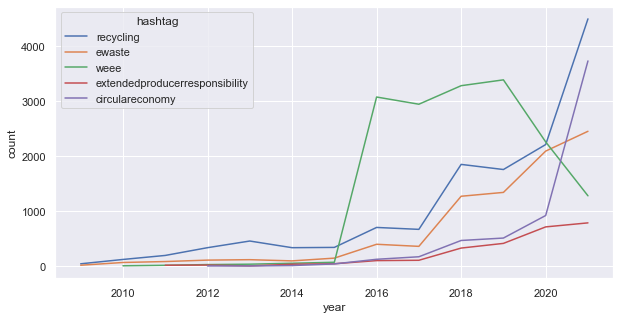

In [144]:
hash_plot = hashPerYear.loc[ (hashPerYear['hashtag'] == 'ewaste') | (hashPerYear['hashtag'] == 'recycling') | 
                              (hashPerYear['hashtag'] == 'extendedproducerresponsibility') | (hashPerYear['hashtag'] == 'recycling')
                                | (hashPerYear['hashtag'] == 'weee') | (hashPerYear['hashtag'] == 'circulareconomy')]

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10,5)})
# Plot the responses for different events and regions
sns.lineplot(x="year", y="count",
             hue="hashtag",
             data=hash_plot)

as we mentioned before, raise of trends through the years is obvious, and sudden changes between in 2016 and 2019 is caused by US withdraw from 2015 paris agreement, also the sudden raise in 2020 is probably because of Tokyo Olympic, Japan used waste of electronic and electrical equipment for medals.

Sentiment analysis will help us to get an idea about how people feel about Waste of electronic and electrical equipments.

In [148]:
analyzer = SentimentIntensityAnalyzer()

In [149]:
# use the polarity_scores() method to get the sentiment metrics
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [150]:
%%time

df['sentiment_neg'] = df['tweet'].apply(negative_score)
df['sentiment_neu'] = df['tweet'].apply(neutral_score)
df['sentiment_pos'] = df['tweet'].apply(positive_score)
df['sentiment_compound'] = df['tweet'].apply(compound_score)

Wall time: 2min 55s


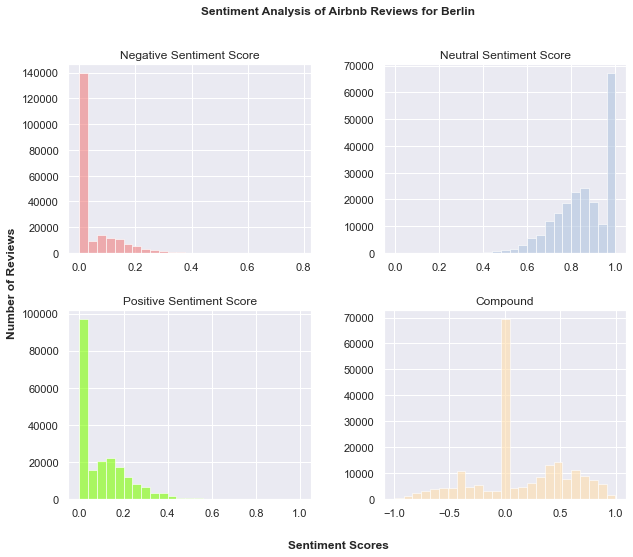

In [95]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Airbnb Reviews for Berlin\n\n', fontsize=12, fontweight='bold');

The results of the sentiment analysis show that most tweets have dealt with the issue in a neutral way, and this creates the need to increase awareness and encouraging people to recycle electronic equipment more important.

Now for doing LDA topic modeling we need to preprocess the data.

In [163]:
# Remove punctuation
df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('[\!?()#&@]', '', x))
# Convert to lowercase
df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: x.lower())
#removing urls
df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: re.sub('https?:\/\/.*[\r\n]*', '', x))
df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: re.sub('www.*[\r\n]*', '', x))
# Print out the first rows of tweets
df['preprocessed_tweet'].head()

<>:2: DeprecationWarning: invalid escape sequence \!
<>:6: DeprecationWarning: invalid escape sequence \/
<>:2: DeprecationWarning: invalid escape sequence \!
<>:6: DeprecationWarning: invalid escape sequence \/
C:\Users\Soroush\AppData\Local\Temp/ipykernel_11256/1179403617.py:2: DeprecationWarning: invalid escape sequence \!
  df['preprocessed_tweet'] = df['tweet'].map(lambda x: re.sub('[\!?()#&@]', '', x))
C:\Users\Soroush\AppData\Local\Temp/ipykernel_11256/1179403617.py:6: DeprecationWarning: invalid escape sequence \/
  df['preprocessed_tweet'] = df['preprocessed_tweet'].map(lambda x: re.sub('https?:\/\/.*[\r\n]*', '', x))


0    we want rfl staff at each of our hospitals to ...
1    nlzerowaste has been working on this for a few...
2    nlzerowaste has launched its 2021 brand audit,...
4    did you know that you can search for projects ...
5    wwlnhs have been able to set their sights on h...
Name: preprocessed_tweet, dtype: object

In [164]:
#A function which takes a sentence/corpus and gets its lemmatized version.
def lemmatizeSentence(sentence):
    token_words=word_tokenize(sentence) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word, pos = "v"))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

def get_wordnet_pos(word):
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

# Lemmatize list of words and join
df['preprocessed_tweet'] = df['preprocessed_tweet'].apply(lambda x: lemmatizeSentence(x))
df['preprocessed_tweet'].head()

0    we want rfl staff at each of our hospitals to ...
1    nlzerowaste have be work on this for a few wee...
2    nlzerowaste have launch its 2021 brand audit ,...
4    do you know that you can search for project to...
5    wwlnhs have be able to set their sight on hims...
Name: preprocessed_tweet, dtype: object

In [165]:
#removing stop words
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.preprocessed_tweet.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['want', 'rfl', 'staff', 'hospitals', 'get', 'involve', 'epr', 'train', 'whichever', 'site', 'base', 'use', 'electronic', 'patient', 'record', 'epr', 'please', 'check', 'review', 'train', 'today', 'find', 'detail', 'need', 'freenet']


In [166]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1)]


In [167]:
num_topics = 7
# create LDA model using preferred hyperparameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=300)

In [ ]:
# Save LDA model to disk
# path_to_model = "/content/drive/MyDrive/Uni/EPR topics & trends/lda.model"
# lda_model.save(path_to_model)

In [168]:
# for each topic, print words occuring in that topic
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.081*"recycle" + 0.020*"phone" + 0.017*"waste" + 0.016*"old" + 0.016*"cell" + 0.014*"day" + 0.012*"apple" + 0.010*"get" + 0.010*"earth" + 0.010*"profit"
Topic: 1 
Words: 0.080*"waste" + 0.020*"recycle" + 0.014*"electronic" + 0.012*"disposal" + 0.011*"day" + 0.009*"weee" + 0.008*"electrical" + 0.008*"management" + 0.007*"amp" + 0.007*"event"
Topic: 2 
Words: 0.057*"recycle" + 0.037*"waste" + 0.019*"electronic" + 0.016*"electrical" + 0.015*"equipment" + 0.013*"weee" + 0.009*"phone" + 0.009*"amp" + 0.009*"samsung" + 0.007*"make"
Topic: 3 
Words: 0.042*"recycle" + 0.024*"program" + 0.022*"apple" + 0.012*"waste" + 0.011*"extend" + 0.010*"amp" + 0.009*"epr" + 0.008*"reuse" + 0.007*"launch" + 0.007*"new"
Topic: 4 
Words: 0.046*"responsibility" + 0.045*"producer" + 0.041*"extend" + 0.034*"waste" + 0.014*"recycle" + 0.009*"epr" + 0.008*"new" + 0.007*"economy" + 0.006*"circular" + 0.006*"cell"
Topic: 5 
Words: 0.059*"phone" + 0.047*"cell" + 0.035*"recycle" + 0.014*"buy" + 0.011

In [169]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=id2word)
vis

C:\Users\Soroush\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.047924  0.074886       1        1  22.964446
2     -0.020269  0.091731       2        1  16.105966
0     -0.083629  0.000593       3        1  14.860994
4      0.133971 -0.047746       4        1  13.740427
6      0.041859  0.017481       5        1  13.676720
5     -0.137145 -0.041135       6        1   9.387949
3      0.017289 -0.095809       7        1   9.263498, topic_info=               Term           Freq          Total Category  logprob  loglift
754           phone   34107.000000   34107.000000  Default  30.0000  30.0000
179  responsibility   23709.000000   23709.000000  Default  29.0000  29.0000
142        producer   23156.000000   23156.000000  Default  28.0000  28.0000
56          recycle  104063.000000  104063.000000  Default  27.0000  27.0000
743            cell   26094.000000   26094.000000  Default  26.0000  26.0000
..              ...            ...            ...      ...      ...      ...
179  responsibility    1201.233603   23709.529243   Topic7  -5.3643  -0.6034
142        producer    1186.935214   23156.215959   Topic7  -5.3763  -0.5918
754           phone    1243.121066   34107.328431   Topic7  -5.3301  -0.9328
20              use     988.640754   12236.422464   Topic7  -5.5591  -0.1368
37               us     957.316761   10035.963483   Topic7  -5.5913   0.0293

[642 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
13196      1  0.041195     academic
13196      5  0.954342     academic
7781       1  0.996962  accessories
27174      1  0.993554        accra
8621       1  0.042045     accredit
...      ...       ...          ...
340        5  0.134335         year
340        6  0.072624         year
340        7  0.306569         year
25120      2  0.993967       zambia
16631      3  0.996253          zoo

[1892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 7, 6, 4])